In [1]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 11

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fpn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [2]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row (Original Image: Ground Truth : Predicted)
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        if name == "original_image":
          #print(image.shape)
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
        else:
          #print(image.shape)
          # get title from the parameter names
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
    plt.show()

#Function to reverse one-hot-encode an image
def reverse_one_hot(image):
    #argmax to return the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [3]:
def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        #albu.RandomScale(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),
        albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY, border_mode=0)
    ]
    return albu.Compose(test_transform)

In [4]:
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from PIL import Image

SIZEX = 128
SIZEY = 128

rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]


class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    print(coords_dir)
    readfile = open(coords_dir, "r")

    self.image_ids = []
    self.coords_ids = []
    for line in readfile:
      try:
        pairs = line.strip().split("\\n")
        split_pairs = [x.replace(" ","").split(",") for x in pairs]
        #print(split_pairs[0][0])
        self.image_ids.append(split_pairs[0][1])
        #print(split_pairs[0][1])
        self.coords_ids.append(split_pairs[0][0])
      except:
        pass

    self.images_fps = [os.path.join(images_dir, image_id+".jpg") for image_id in self.image_ids]
    self.masks_fps_folders = [os.path.join(masks_dir, mask_id+"/") for mask_id in self.image_ids]
    self.coords_fps = [os.path.join("/home/nathan/Documents/final_project/datasets/helen1/coords/", coord_id+".txt") for coord_id in self.coords_ids]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # merge masks
    masks1 = [os.path.join(self.masks_fps_folders[i], mask_id) for mask_id in sorted(os.listdir(self.masks_fps_folders[i]))]

    flat = None
    for count, mask in enumerate(masks1):
        test = cv2.imread(masks1[count], cv2.IMREAD_GRAYSCALE)
        #test = cv2.cvtColor(test, cv2.COLOR_GRAY2BGRA)
        test = np.array(test)
        #test = cv2.resize(test, (SIZEY, SIZEY))
        #print(test.shape)
        #print(np.unique(test))
        test[test > 125] = 255
        test[test < 255] = 0
        test[test == 255] = count
        test[test == 0] = 255
        #print(np.unique(test))
        # Make 4-channel RGBA black background with same height and width
        im = np.zeros((*test.shape,4), dtype=np.uint8)
        # Put your alpha channel in, inverted
        im[:,:,3] = 255 - test
        #print(im.shape)
        #print(np.unique(test))
        im = Image.fromarray(im)
        #plt.imshow(im)
        #plt.show()
        if count == 0:
            flat = im
        else:
            flat.paste(im, (0,0), im)

    flat = np.array(flat)
    #print(np.unique(flat[:,:,3]))
    #print(flat[:,:,3].shape)
    gray_flat = flat[:,:,3]
    gray_flat = 255 - gray_flat
    gray_flat[gray_flat == 255] = 0
    mask = gray_flat /2
    #print(mask.shape)
    #visualize(og=image,mask=mask)

    #print(self.image_ids[i])
    #print(self.coords_ids[i])
    #print(self.coords_fps[i])    
    
    # crop to center 
    
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    readfile = open(self.coords_fps[i], "r")
    for count, line in enumerate(readfile):
      pairs = line.strip().split("\\n")
      contents = [x.replace(" ","").split(",") for x in pairs][0]
      if count != 0:
        #print(contents)
        contents = np.array(contents).astype(float)
        if (contents[0]) < smallest_x:
          smallest_x = (contents[0])
        
        if (contents[0]) > biggest_x:
          biggest_x = (contents[0])

        if (contents[1]) < smallest_y:
          smallest_y = (contents[1])
        
        if (contents[1]) > biggest_y:
          biggest_y = (contents[1])
        else:
          pass

    crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

    #print(crop_coords)

    image = image[int(smallest_y)-20: int(biggest_y), int(smallest_x):int(biggest_x)]
    mask = mask[int(smallest_y)-20: int(biggest_y), int(smallest_x):int(biggest_x)]

    try:
      mask = cv2.resize(mask, (SIZEY, SIZEY))
      image = cv2.resize(image, (SIZEY, SIZEY))
      mask = np.expand_dims(mask,2)
    except:
      #print(self.image_ids[i])
      #print(self.coords_ids[i])
      #print(masks1)
      return self.__getitem__(i-1)   

    #print(mask.shape, image.shape)
    #visualize(og=image,mask=mask)
    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)


    # apply augmentations
    if self.augmentation:
      #print("augmenting")
      sample = self.augmentation(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']
      #print(mask.shape, image.shape)
    
    # apply preprocessing
    if self.preprocessing:
      #print("preprocessing")
      sample = self.preprocessing(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).permute(0,3,1,2).float()

    #print("returning")

    return (image, one_hot_Y.squeeze(0))


train_x_path = "/home/nathan/Documents/final_project/datasets/helen1/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/helen1/labels"
train_coords_path = "/home/nathan/Documents/final_project/datasets/helen1/exemplars.txt"

val_x_path = "/home/nathan/Documents/final_project/datasets/helen1/images"
val_y_path = "/home/nathan/Documents/final_project/datasets/helen1/labels"
val_coords_path = "/home/nathan/Documents/final_project/datasets/helen1/tuning.txt"

test_x_path = "/home/nathan/Documents/final_project/datasets/helen1/images"
test_y_path = "/home/nathan/Documents/final_project/datasets/helen1/labels"
test_coords_path = "/home/nathan/Documents/final_project/datasets/helen1/testing.txt"

train_ds = MyDataSet(train_x_path, train_y_path, train_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation())
val_ds = MyDataSet(val_x_path, val_y_path, val_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())
test_ds = MyDataSet(test_x_path, test_y_path, test_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())

/home/nathan/Documents/final_project/datasets/helen1/exemplars.txt
/home/nathan/Documents/final_project/datasets/helen1/tuning.txt
/home/nathan/Documents/final_project/datasets/helen1/testing.txt


/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


/tmp/ipykernel_58320/853188052.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


0 : (3, 128, 128) torch.Size([11, 128, 128])


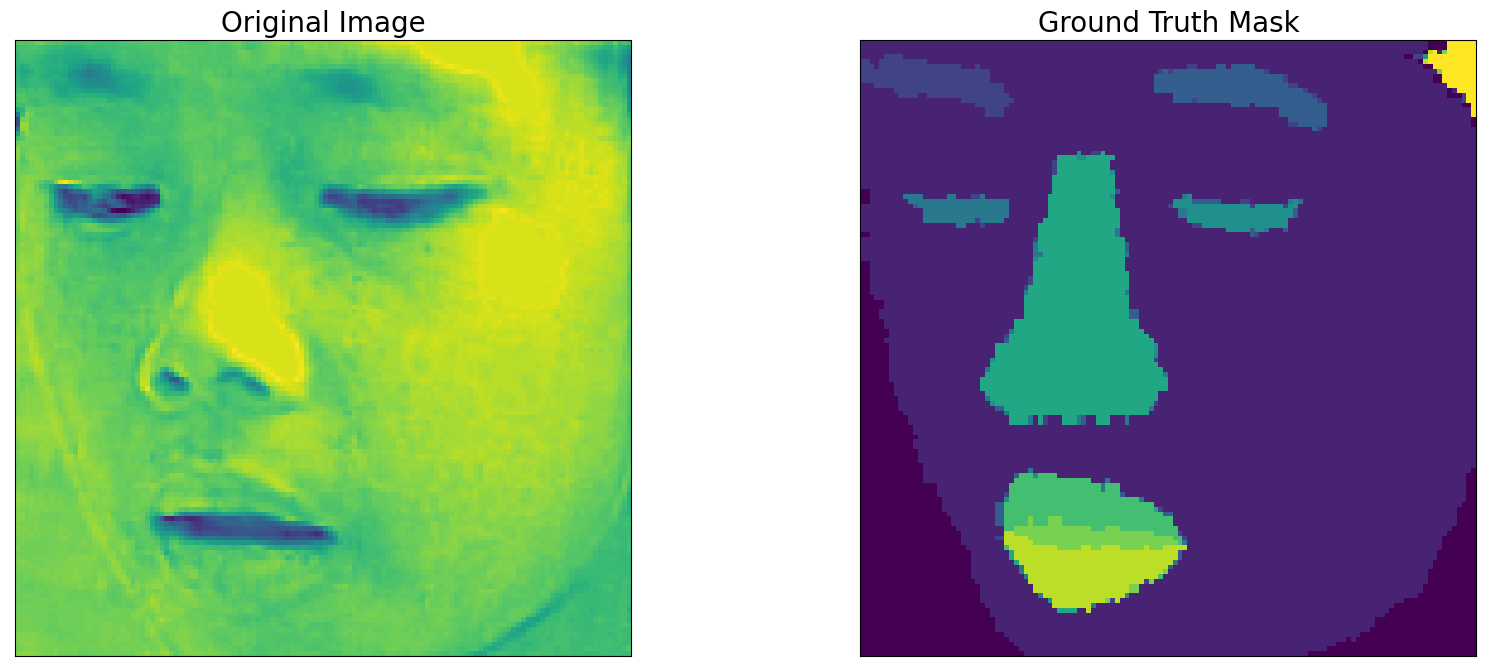

1 : (3, 128, 128) torch.Size([11, 128, 128])


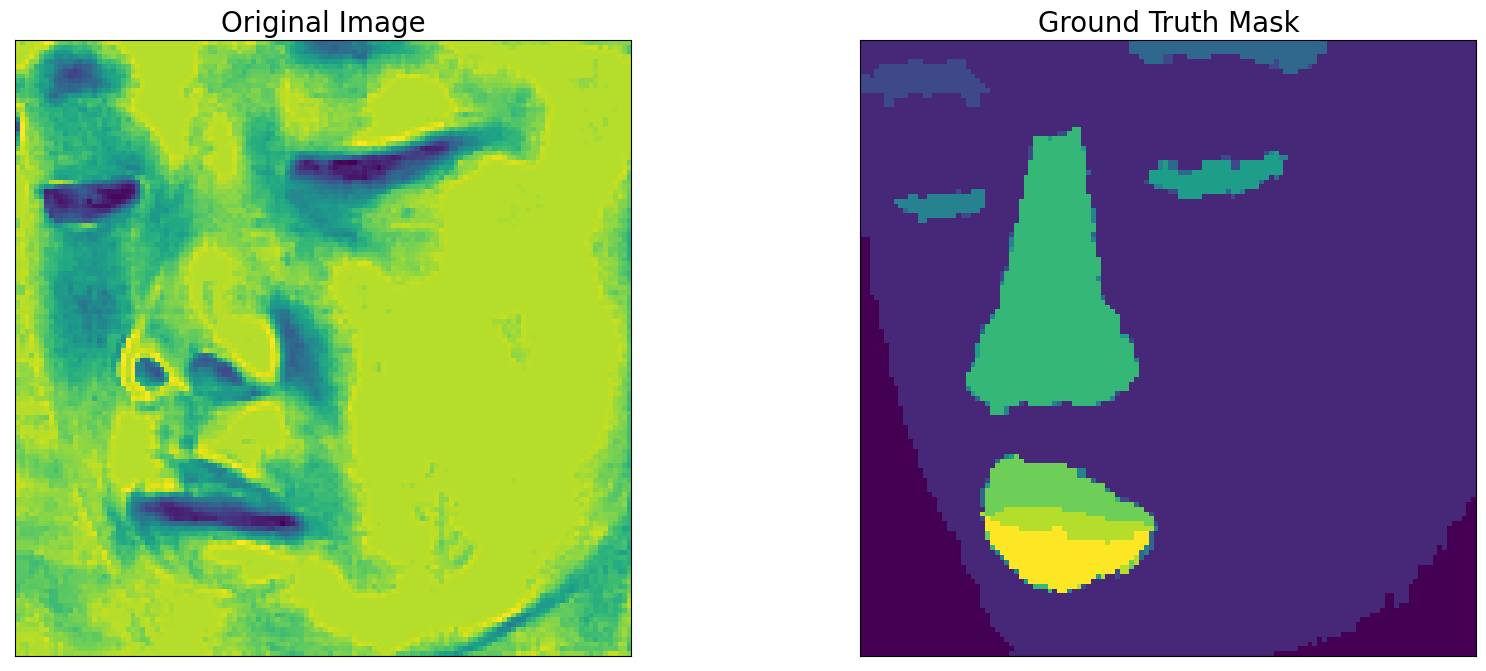

2 : (3, 128, 128) torch.Size([11, 128, 128])


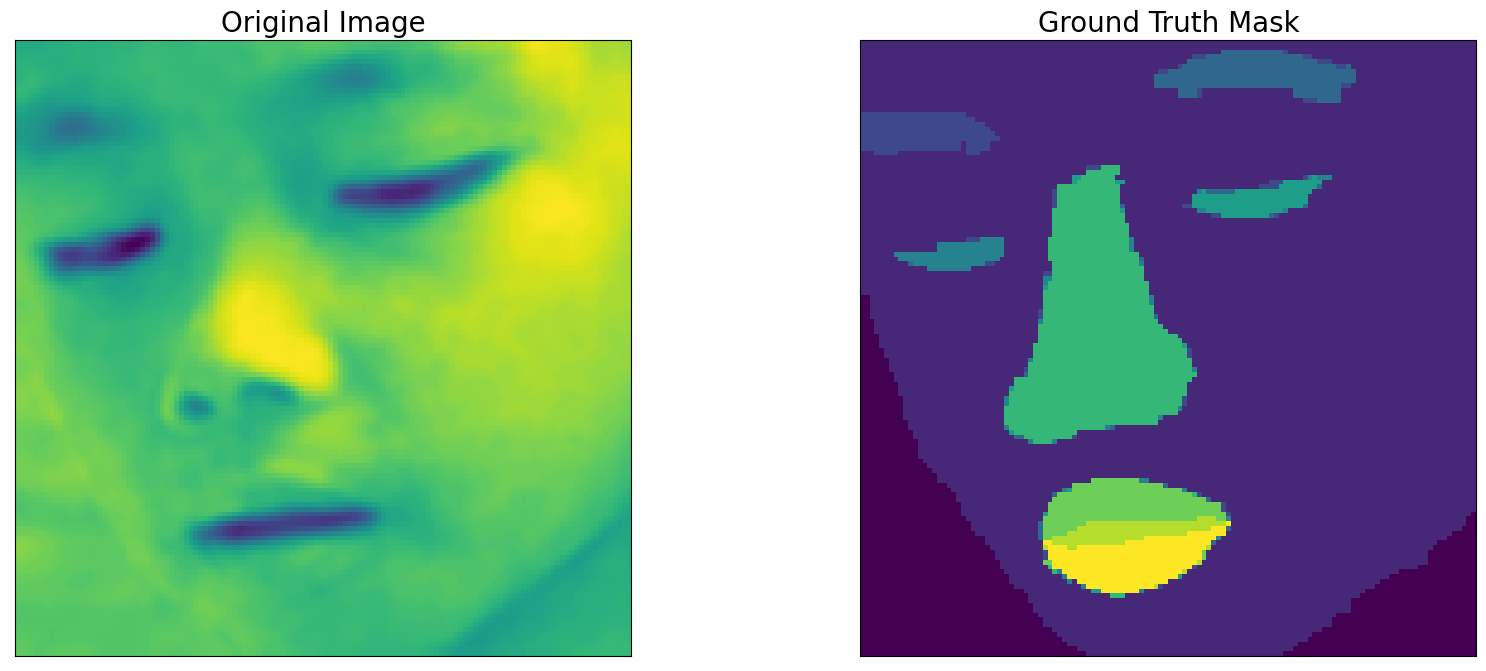

In [5]:
from matplotlib import pyplot as plt

for x in range(3):

  image_vis, gt_mask = train_ds[9]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

for x in range(0):

  image_vis, gt_mask = val_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

#np.unique(image_vis)

In [6]:
len(train_ds)

2000

### Data Loader

In [7]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=7)
valid_loader = DataLoader(val_ds, batch_size=24, shuffle=False, num_workers=7)

print(len(train_loader))

84


## Hyper Params

In [8]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing

weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights



tensor([0.9029, 0.3229, 0.9836, 0.9837, 0.9889, 0.9894, 0.9219, 0.9869, 0.9836,
        0.9778, 0.9584])

In [9]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda")


#[0.1, 1, 1, 1, 1, 1, 0.8, 1, 0.8, 1, 0.1]
#weights = weights=torch.tensor()
# define loss function
#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


## Train Model

In [10]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            if best_iou_score>0.8:
              optimizer.param_groups[0]['lr'] = 1e-5
              print('Decrease decoder learning rate to 1e-5!')
                
            # Append results to graphs:
           # v_bce.append(valid_logs['bce_loss'])
            v_ious.append(valid_logs['iou_score'])
            
            #t_bce.append(train_logs['bce_loss'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                #plt.plot(epoch_count,t_bce, label="Train ce")
#plt.plot(epoch_count,v_bce, label="Valid ce")
                #.legend(loc="upper left")
               # plt.xlabel("Epochs")
               # plt.ylabel("BCE Loss")
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


### Function to view train model precitions

In [11]:
! pip install torchmetrics

/bin/bash: /home/nathan/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [15]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        #print("vis:",image_vis.shape)
        #print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        #print("predraw", pred_mask.shape)
        #print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          #print(f1)
          f1s.append(np.array(f1))

        if idx < 1:
          visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

/tmp/ipykernel_58320/2171663887.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Predict with models


Epoch: 1
valid: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it, cross_entropy_loss - 0.9051, iou_score - 0.6159]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, cross_entropy_loss - 0.8896, iou_score - 0.6432]
Model saved!


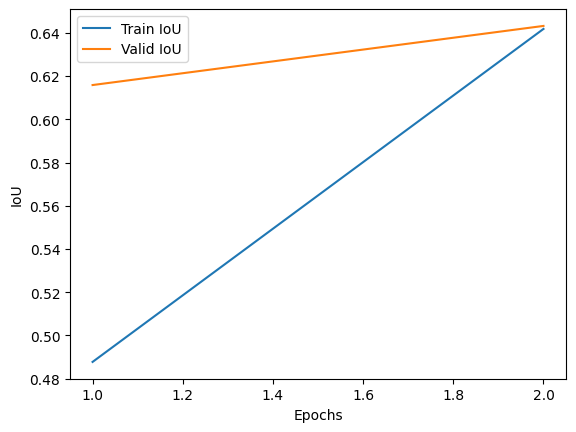


Epoch: 3
valid: 100%|██████████| 10/10 [00:32<00:00,  3.30s/it, cross_entropy_loss - 0.8793, iou_score - 0.675]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:32<00:00,  3.25s/it, cross_entropy_loss - 0.876, iou_score - 0.6978]
Model saved!


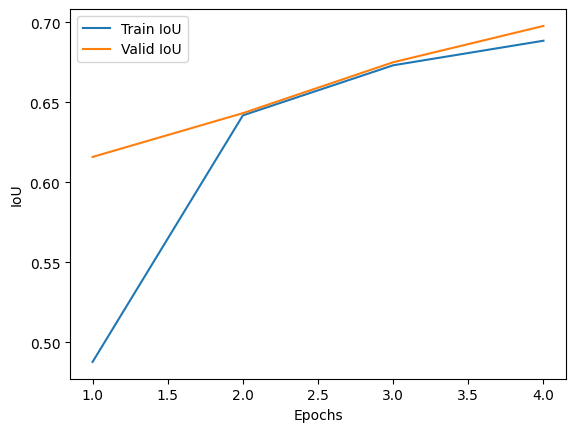


Epoch: 5
valid: 100%|██████████| 10/10 [00:32<00:00,  3.21s/it, cross_entropy_loss - 0.8861, iou_score - 0.6281]

Epoch: 6
valid: 100%|██████████| 10/10 [00:32<00:00,  3.21s/it, cross_entropy_loss - 0.8727, iou_score - 0.7052]
Model saved!


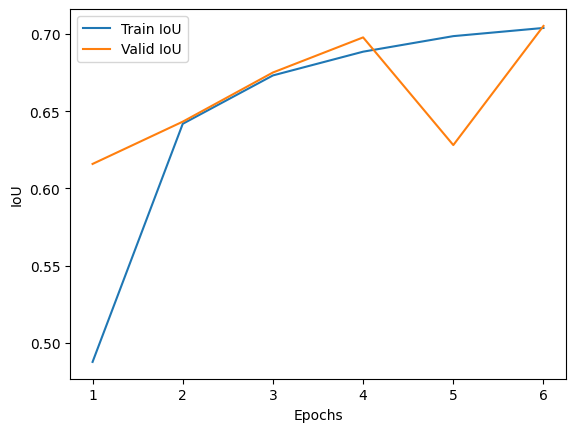


Epoch: 7
valid: 100%|██████████| 10/10 [00:32<00:00,  3.22s/it, cross_entropy_loss - 0.8709, iou_score - 0.7189]
Model saved!

Epoch: 8
valid: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it, cross_entropy_loss - 0.8683, iou_score - 0.7249]
Model saved!


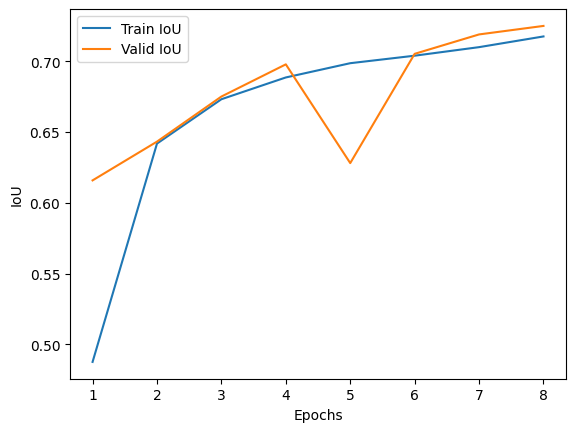


Epoch: 9
valid: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it, cross_entropy_loss - 0.8703, iou_score - 0.71] 

Epoch: 10
valid: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it, cross_entropy_loss - 0.8682, iou_score - 0.7243]


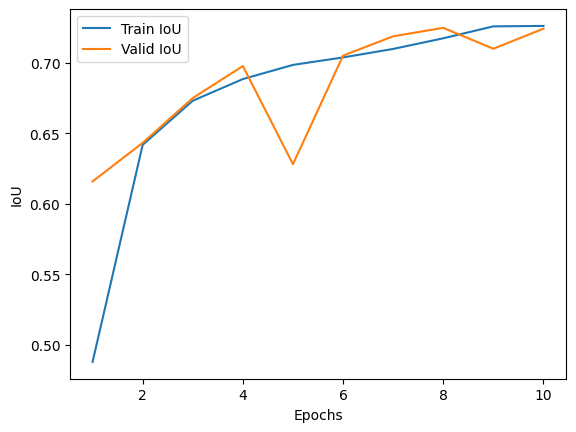


Epoch: 11
valid: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it, cross_entropy_loss - 0.8698, iou_score - 0.706]

Epoch: 12
valid: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, cross_entropy_loss - 0.8671, iou_score - 0.7421]
Model saved!


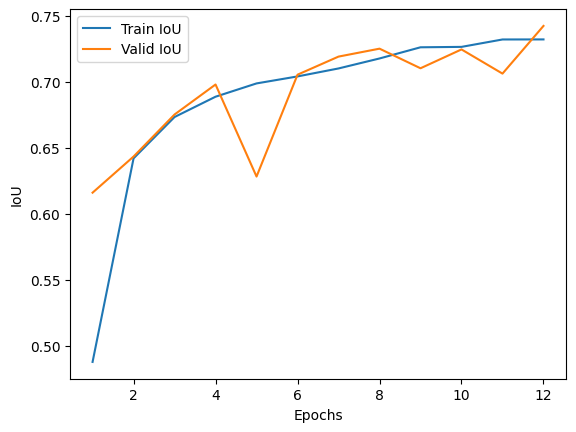


Epoch: 13
train:   0%|          | 0/84 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [14]:
#train_model(unet, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/helen/unet.pth", 50)
#train_model(mobile, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/helen/mobile.pth", 50)
#train_model(deeplab, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/helen/deeplab.pth", 50)
#train_model(fpn, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/helen/fcn.pth", 50)

### Load and view model predictions

HELEN:


/tmp/ipykernel_58320/2171663887.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


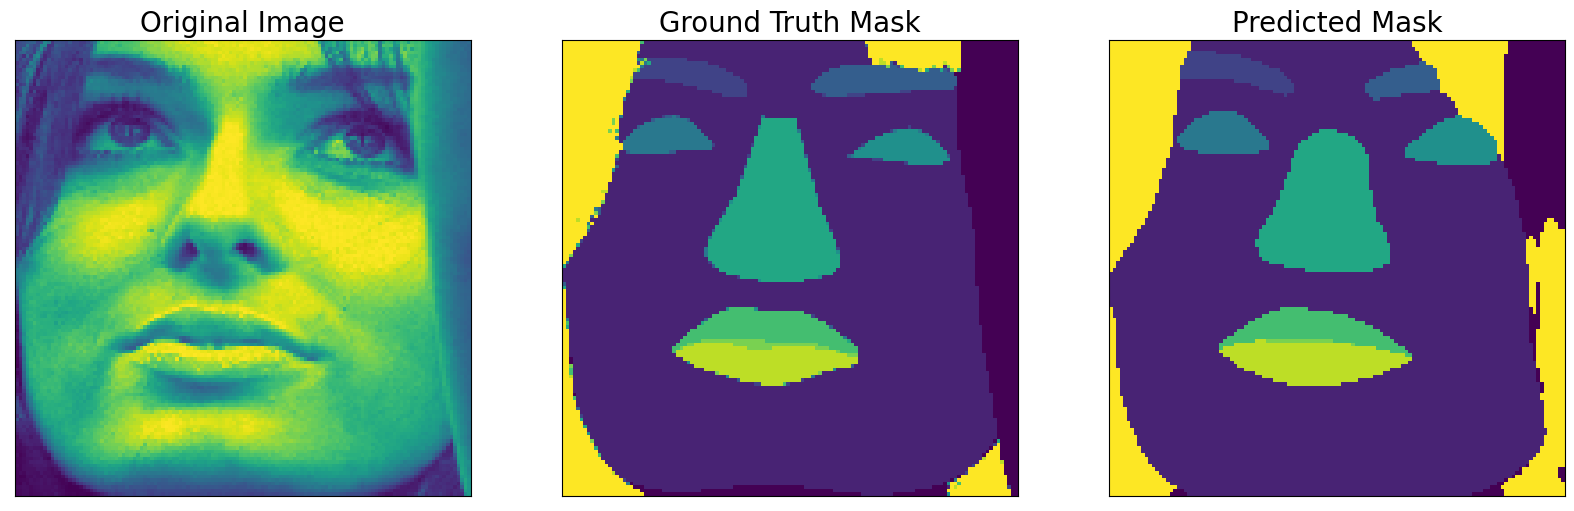

Dataset MIoU =  0.6317543146014214
Dataset F1 =  [0.8257212  0.94469315 0.7032621  0.7142385  0.75265324 0.74657524
 0.8962683  0.71987844 0.6727636  0.79802465 0.75557274]
Dataset F1 av =  0.7754229


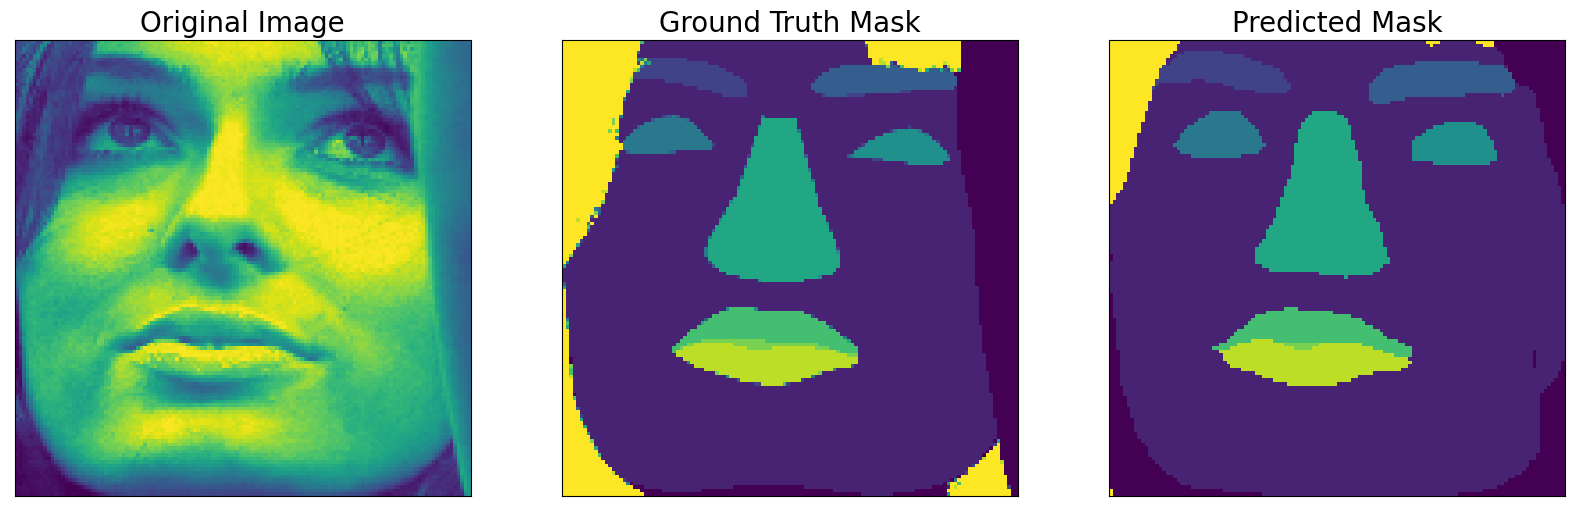

Dataset MIoU =  0.5883082151412964
Dataset F1 =  [0.7561024  0.9439857  0.6857645  0.67202437 0.7331088  0.7335519
 0.92155564 0.6915726  0.7059166  0.7757032  0.5392891 ]
Dataset F1 av =  0.74168867


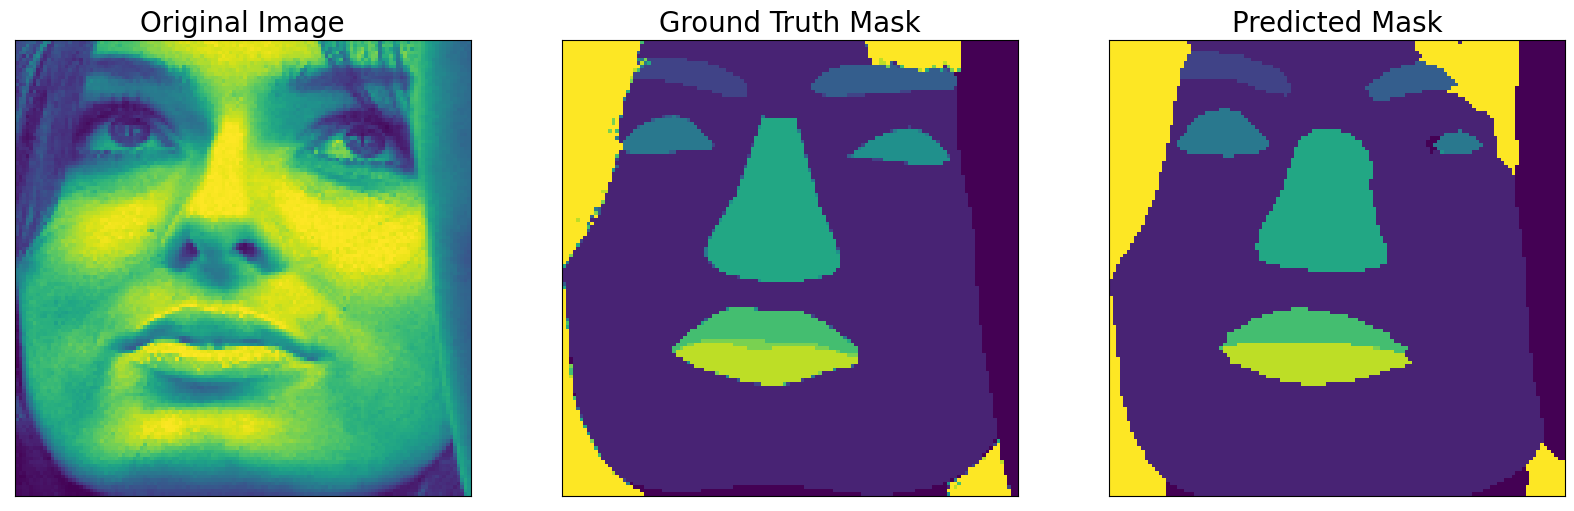

Dataset MIoU =  0.5753642082214355
Dataset F1 =  [0.83333415 0.94260603 0.7124505  0.71026665 0.69666564 0.24715489
 0.8968505  0.70124334 0.67579633 0.79497546 0.77179134]
Dataset F1 av =  0.72573954


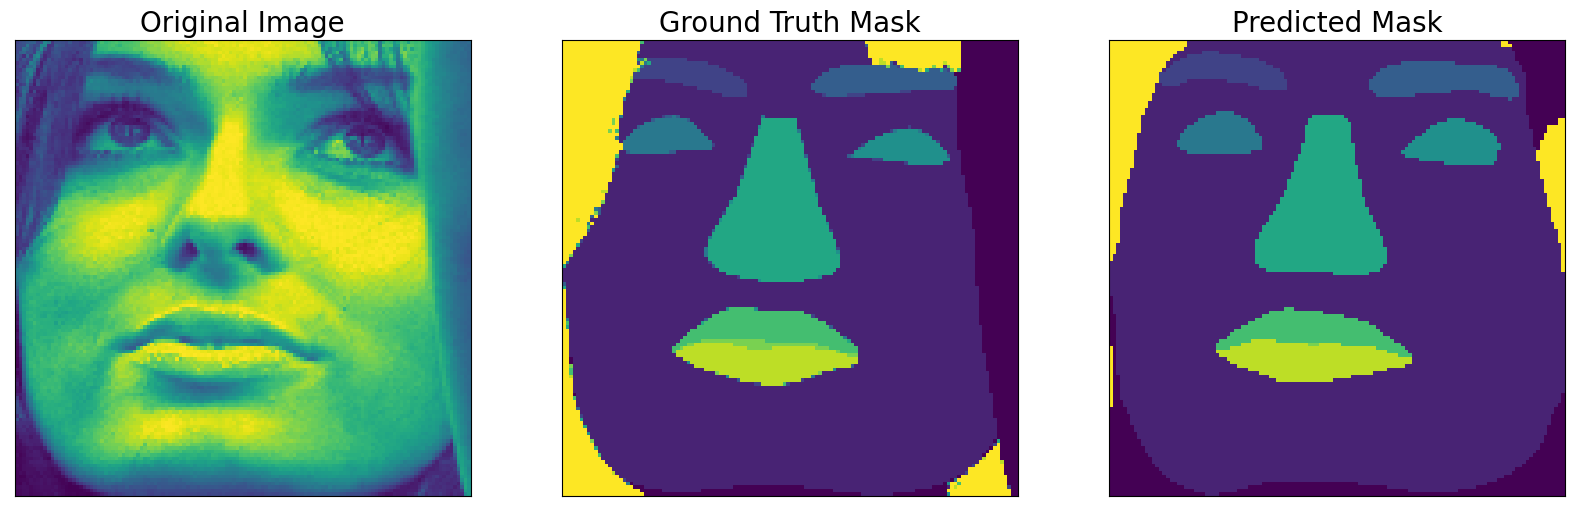

Dataset MIoU =  0.6257767325639725
Dataset F1 =  [0.7726709  0.95081854 0.7149682  0.7232262  0.76258576 0.77170485
 0.93334496 0.733294   0.7177324  0.82463604 0.59594834]
Dataset F1 av =  0.7728119


In [23]:
print("HELEN:")

model = torch.load("/home/nathan/Documents/final_project/saved_models/helen/mobile.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/helen/deeplab.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/helen/fcn.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/helen/unet.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)
